In [ ]:
import re
import numpy as np
import os
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import spacy
from elasticsearch import Elasticsearch
from datetime import datetime
from elasticsearch.helpers import bulk
import matplotlib.pyplot as plt


In [ ]:
es = Elasticsearch(
    [{'host': 'localhost', 'port': 9200, 'scheme': 'http'}],
    http_auth=('emad2', 'emadmassri'))

index_name = "news_index"

In [ ]:
if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)

configurations = {
    "mappings": {
        "properties": {
            "Title": {
                "type": "text",
                "analyzer": "autocomplete_analyzer",
            },
            "Content": {
                "type": "text",
                "analyzer": "content_analyzer"
            },
            "Authors": {
                "type": "nested",
                "properties": {
                    "first_name": {
                        "type": "text",
                        "analyzer": "standard"
                    },
                    "last_name": {
                        "type": "text",
                        "analyzer": "standard"
                    },
                    "email": {
                        "type": "keyword"
                    }
                }
            },
            "Date": {
                "type": "date"
            },
            "Coordinates": {
                "type": "geo_point"
            },
            "TemporalExpressions": {
                "type": "nested"
            },
            "Georeferences": {
                "type": "nested"
            }
        }
    },
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 1,
        "analysis": {
            "analyzer": {
                "autocomplete_analyzer": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "filter": [
                        "lowercase",
                        "autocomplete_filter"
                    ]
                },
                "content_analyzer": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "filter": [
                        "lowercase",
                        "stop_filter",
                        "stemmer_filter",
                        "fuzzy_filter"
                    ]
                }
            },
            "filter": {
                "autocomplete_filter": {
                    "type": "edge_ngram",
                    "min_gram": 3,
                    "max_gram": 15
                },
                "fuzzy_filter": {
                    "type": "fuzzy",
                    "fuzziness": "2"
                },
                "stop_filter": {
                    "type": "stop",
                    "stopwords": "_english_"
                },
                "stemmer_filter": {
                    "type": "porter_stem"
                }
            }
        }
    }
}


es.indices.create(index=index_name, ignore=400, body=configurations)

In [ ]:
nlp = spacy.load("en_core_web_sm")
geolocator = Nominatim(user_agent="geo_app", timeout=10)

Tokenize the text by convert to lowercase and remove stop words and tokens with length < 3, and perform stemming

In [ ]:
def clean_content(content):
    clean_content = re.sub(r'<[^>]+>', '', content)
    
    tokens = word_tokenize(clean_content.lower())  
    
    
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    
    
    processed_text = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) >= 3]
    processed_paragraph = ' '.join(processed_text)
    
    
    return processed_paragraph

In [ ]:
def extract_author_info(author_tag):
    authors_info = []
    
    if author_tag:
        author_text = author_tag.get_text().strip().replace('by ', '')
        authors = author_text.split(',')
        
        
        for author in authors:
            parts = author.strip().split()
            
            
            if len(parts) >= 1:
                first_name = parts[0]
                last_name = ' '.join(parts[1:])
                
                
                author_info = {
                    "first_name": first_name.strip(),
                    "last_name": last_name.strip()if last_name else None,
                    "email": None  
                }
                authors_info.append(author_info)
    
    
    return authors_info if authors_info else None


In [ ]:
def convert_date(date_tags):
    date_obj = None
    
    if date_tags and isinstance(date_tags, list): 
        date_tag = date_tags[0]
        date_str = date_tag.text.strip()

        try:
            date_obj = datetime.strptime(date_str, "%d-%b-%Y %H:%M:%S.%f")
        except ValueError:
            print(f"Error: Unable to parse date string '{date_str}'")
    
    return date_obj


In [ ]:
def process_reuters_tags(soup):
    documents = [] 
    for reuters_tag in soup.find_all('reuters'):
        
        date = convert_date([reuters_tag.find('date')]) if reuters_tag.find('date') else None
        
        
        topics = [topic.get_text() for topic in reuters_tag.find('topics').find_all('d')] if reuters_tag.find('topics') else None
        
        
        places = [place.get_text() for place in reuters_tag.find('places').find_all('d')] if reuters_tag.find('places') else None
        
        
        title = reuters_tag.find('title').get_text() if reuters_tag.find('title') else None
        
        
        author_tag = reuters_tag.find('author')
        author_info = extract_author_info(author_tag) if author_tag else None
        
        
        content = reuters_tag.find('text').get_text() if reuters_tag.find('text') else None
        
        
        content = clean_content(content) if content else None
        
        georeferences = []
        coordinates = []
        
        
        for place_name in places or []:
            location = geolocator.geocode(place_name)
            if location:
                georeferences.append({
                    "name": place_name,
                })
                coordinates.append({'latitude': location.latitude, 'longitude': location.longitude})
                
        average_location = {
            "lat": np.mean([point["latitude"] for point in coordinates]),
            "lon": np.mean([point["longitude"] for point in coordinates])
        } if coordinates else None
        
        temporal_expressions = []
        if content:
            doc = nlp(content)
            temporal_expressions =[{
                "DATE": ent.text,
            } for ent in doc.ents if ent.label_ == 'DATE']
        
        
        document_dict = {
            "Topics": topics,
            "Title": title,
            "Content": content,
            "Authors": author_info,
            "Date": date,
            "Georeferences": georeferences,
            "Coordinates": average_location,
            "TemporalExpressions": temporal_expressions,
        }
        documents.append(document_dict)
        
        # es.index(index=index_name, body=document_dict)
    bulk_data = [
        {
            "_index": index_name,
            "_source": doc
        }
        for doc in documents
    ]
    success, failed = bulk(es, bulk_data)
    
    print(f"success: {success}")
    if failed:
        print(f"Failed indexing: {failed}")

In [ ]:
for filename in os.listdir('./archive'):
    if filename.endswith('.sgm'):
        file_path = os.path.join('./archive', filename)
        
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            sgm_content = file.read()
        
        soup = BeautifulSoup(sgm_content, 'html.parser')
        
        process_reuters_tags(soup)

In [ ]:
def search_documents(query, temporal_expression, georeference):
    search_body = {
        "_source": ["Title", "Content", "Date", "Coordinates"],
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": query,
                        "fields": ["Title^3", "Content"]
                    }
                },
                "should": [
                    {"match": {"TemporalExpressions.DATE": temporal_expression}},
                    {"match": {"Georeferences.name": georeference}}
                ],
                "minimum_should_match": 1,
                "boost": 1.0
            }
        },
        "sort": [
            "_score"
        ]
    }

    results = es.search(index=index_name, body=search_body)

    relevant_documents = [
        {
            'Title': hit['_source']['Title'],
            'Content': hit['_source']['Content'],
            'Date': hit['_source']['Date'],
            'Coordinates': hit['_source']['Coordinates']
        }
        for hit in results['hits']['hits']
    ]

    return relevant_documents

user_query = ("bahia cocoa", "week", "usa")
query_result = search_documents(*user_query)

for doc in query_result:
    print(f"Title: {doc['Title']}")
    print(f"Content: {doc['Content']}")
    print(f"Date: {doc['Date']}")
    print(f"Coordinates: {doc['Coordinates']}")
    print("==================" )


In [40]:
def get_top_georeferences():
    aggregation_query = {
        "aggs": {
            "top_georeferences": {
                "terms": {
                    "field": "Georeferences.name.keyword",
                    "size": 10 
                }
            }
        }
    }


    results = es.search(index=index_name, body=aggregation_query)

    nested_aggregation = results.get('aggregations', {}).get('top_georeferences', {})
    buckets = nested_aggregation.get('buckets', [])
    top_georeferences = [{"key": nested_bucket['key'], "document_count": nested_bucket['doc_count']} for nested_bucket in buckets]

    return top_georeferences


top_georeferences = get_top_georeferences()
top_georeferences

[{'key': 'usa', 'document_count': 5569},
 {'key': 'uk', 'document_count': 679},
 {'key': 'canada', 'document_count': 528},
 {'key': 'japan', 'document_count': 369},
 {'key': 'west-germany', 'document_count': 241},
 {'key': 'france', 'document_count': 208},
 {'key': 'brazil', 'document_count': 168},
 {'key': 'belgium', 'document_count': 114},
 {'key': 'australia', 'document_count': 110},
 {'key': 'ussr', 'document_count': 105}]

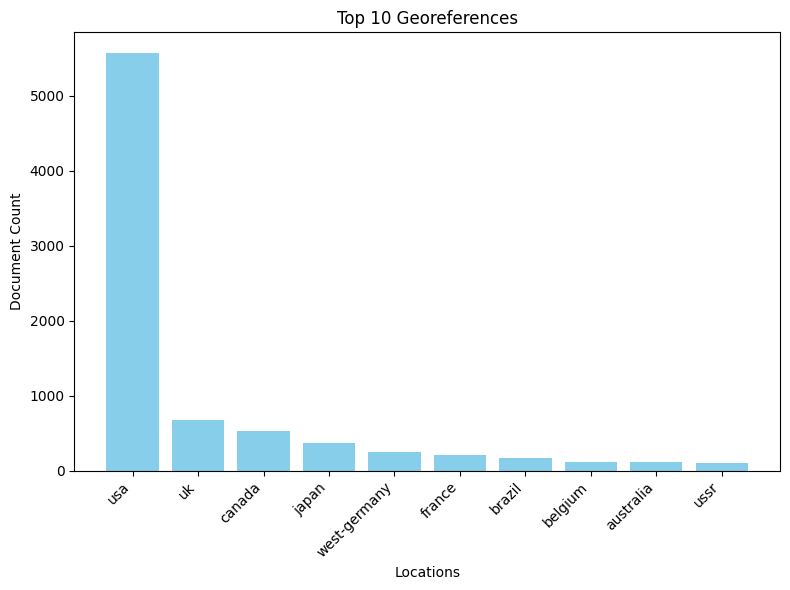

In [41]:
locations = [entry["key"] for entry in top_georeferences]
counts = [entry["document_count"] for entry in top_georeferences]

plt.figure(figsize=(8, 6))
plt.bar(locations, counts, color='skyblue')
plt.xlabel('Locations')
plt.ylabel('Document Count')
plt.title('Top 10 Georeferences')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()

In [38]:


def get_document_distribution_over_time():
    distribution_query = {
        "aggs": {
            "documents_over_time": {
                "date_histogram": {
                    "field": "Date",
                    "fixed_interval": "1d", 
                    "format": "dd-MMM-yyyy HH:mm:ss.SSS",
                    "order": {"_key": "asc"}  
                }
            }
        }
    }

    results = es.search(index=index_name, body=distribution_query)

    document_distribution = [
        {
            'date': datetime.strptime(bucket['key_as_string'], "%d-%b-%Y %H:%M:%S.%f"),
            'count': bucket['doc_count']
        }
        for bucket in results['aggregations']['documents_over_time']['buckets']
    ]

    return document_distribution


time_distribution = get_document_distribution_over_time()
for entry in time_distribution:
    print(f"Date: {entry['date'].strftime('%Y-%m-%d')} - Document Count: {entry['count']}")


Date: 1987-02-26 - Document Count: 8
Date: 1987-02-27 - Document Count: 0
Date: 1987-02-28 - Document Count: 0
Date: 1987-03-01 - Document Count: 0
Date: 1987-03-02 - Document Count: 0
Date: 1987-03-03 - Document Count: 416
Date: 1987-03-04 - Document Count: 490
Date: 1987-03-05 - Document Count: 650
Date: 1987-03-06 - Document Count: 400
Date: 1987-03-07 - Document Count: 15
Date: 1987-03-08 - Document Count: 0
Date: 1987-03-09 - Document Count: 469
Date: 1987-03-10 - Document Count: 0
Date: 1987-03-11 - Document Count: 608
Date: 1987-03-12 - Document Count: 579
Date: 1987-03-13 - Document Count: 512
Date: 1987-03-14 - Document Count: 18
Date: 1987-03-15 - Document Count: 34
Date: 1987-03-16 - Document Count: 589
Date: 1987-03-17 - Document Count: 552
Date: 1987-03-18 - Document Count: 618
Date: 1987-03-19 - Document Count: 588
Date: 1987-03-20 - Document Count: 521
Date: 1987-03-21 - Document Count: 14
Date: 1987-03-22 - Document Count: 42
Date: 1987-03-23 - Document Count: 475
Date:

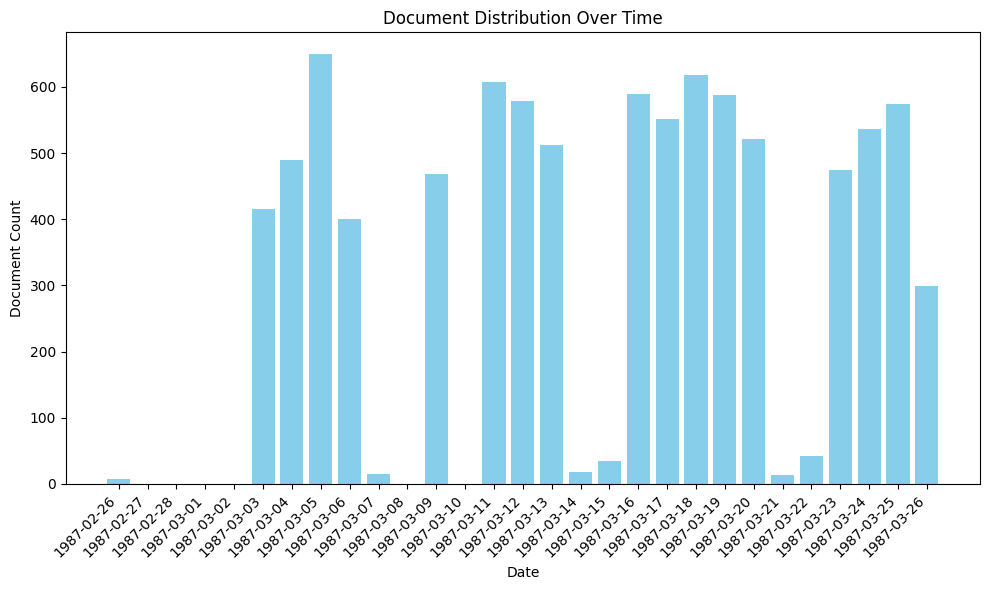

In [39]:
dates = [entry['date'].strftime('%Y-%m-%d') for entry in time_distribution]
counts = [entry['count'] for entry in time_distribution]

plt.figure(figsize=(10, 6))
plt.bar(dates, counts, color='skyblue')
plt.xlabel('Date')
plt.ylabel('Document Count')
plt.title('Document Distribution Over Time')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()